<h1 align=center style="line-height:200%;color:#0099cc">
<font color="#0099cc">
Mall Customer Segmentation
</font>
</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


<h2 style="line-height:200%;color:#0099cc">
<font color="#0099cc">
Dataset Introduction
</font>
</h2>

<p style="line-height:200%;font-size:medium">
<font  size="3">
The training dataset contains 200 rows and 5 columns.
</font>
</p>

<div dir="rtl" style="direction: rtl;text-align: right;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazirmatn" size="3">

| Column | Description |
|--------|-------------|
| CustomerID | Customer identifier |
| Gender | Customer's gender |
| Age | Customer's age |
| Annual Income (k$) | Customer's annual income in thousand dollars |
| Spending Score (1-100) | Customer's spending tendency. Higher numbers indicate a stronger willingness to spend money! |

</font>
</div>


In [2]:
df = pd.read_csv('../data/mall_customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
df.iloc[:,[2,3,4]].corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


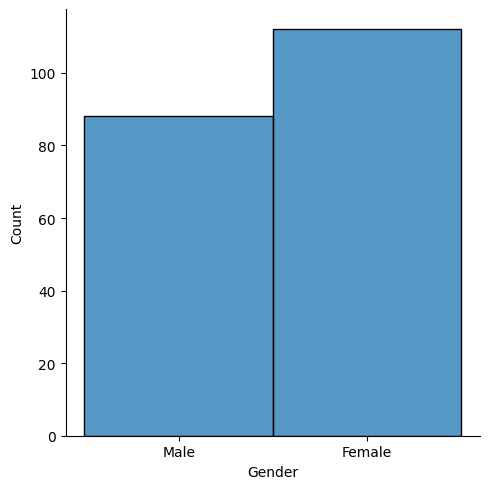

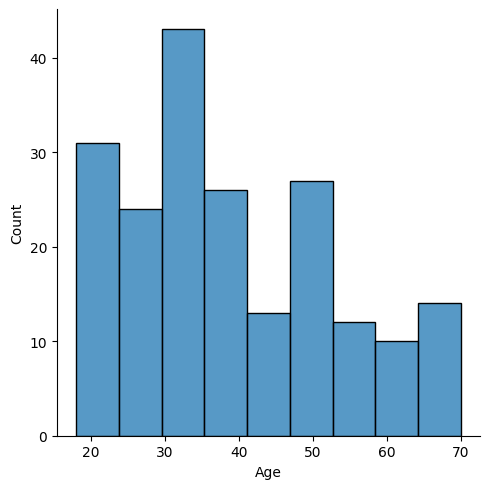

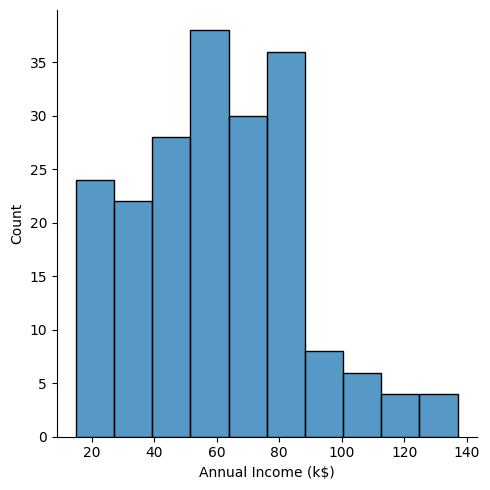

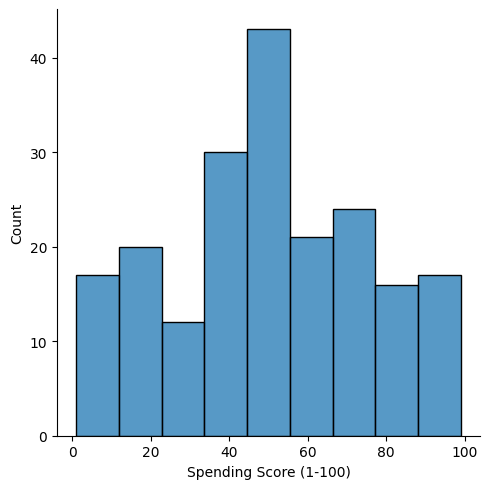

In [6]:
for col in df.columns[1:]:
    sns.displot(df[col])

Does gender affect on income or other variables?

It seems gender does'nt significant affect on other variables but noticable.

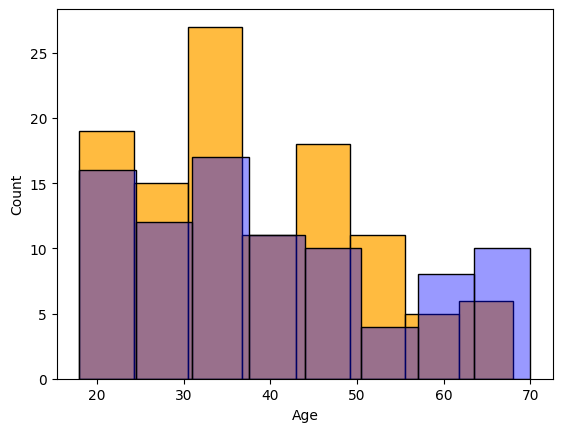

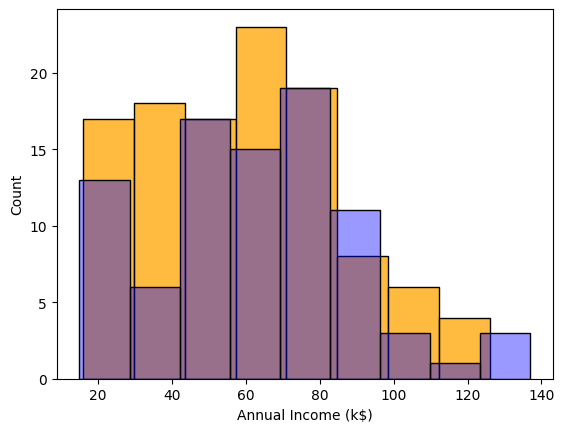

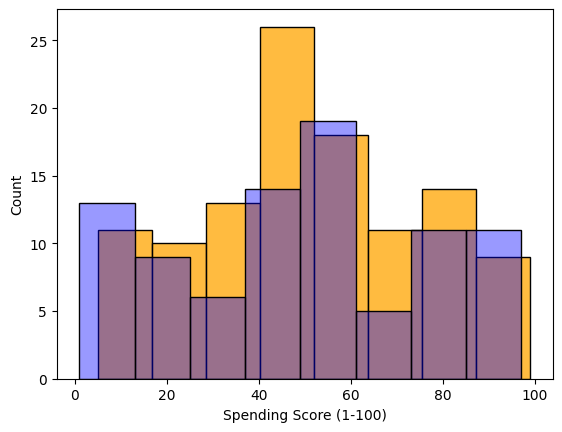

In [7]:
df.groupby('Gender').mean()
male_df = df[df['Gender']=='Male']
female_df = df[df['Gender']=='Female']
for col in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    sns.histplot(female_df[col], color='orange')
    sns.histplot(male_df[col], color='blue', alpha=.4 )
    plt.show()

What about Age?Does it affect on other varibles?

Age does have any effect on income amount and slightly affect on spending score(correlation of age and spending score is -0.3)

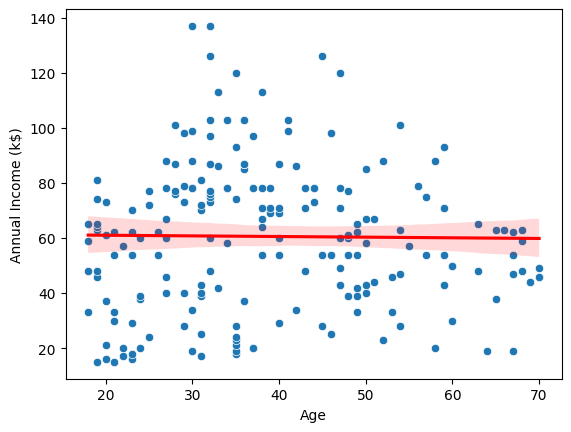

<Axes: xlabel='Age', ylabel='Spending Score (1-100)'>

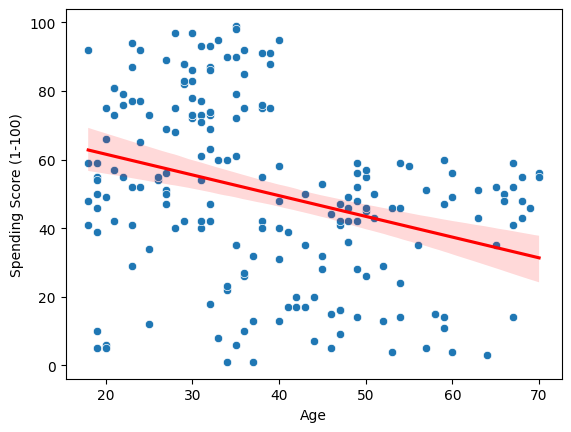

In [8]:
sns.scatterplot(x=df['Age'], y=df['Annual Income (k$)'])
sns.regplot(x=df['Age'], y=df['Annual Income (k$)'], scatter=False, color='red')
plt.show()
sns.scatterplot(x=df['Age'], y=df['Spending Score (1-100)'])
sns.regplot(x=df['Age'], y=df['Spending Score (1-100)'], scatter=False, color='red')

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Annual Income (k$)'}>],
       [<Axes: title={'center': 'Spending Score (1-100)'}>, <Axes: >]],
      dtype=object)

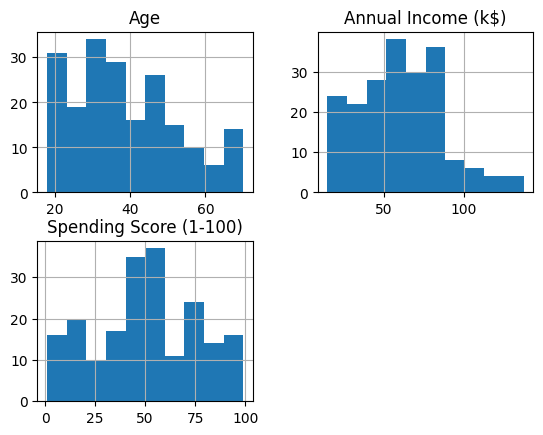

In [9]:
df.iloc[: ,[2,3,4]].hist()

<h2> Preprocessing </h2>

In [10]:
class Preprocessor:
    def __init__(self, df):
        self.df = df.copy()

    def handle_missing_values(self):
        self.df.fillna(0, inplace=True)

    def drop_outlier(self):
        numerical_columns = self.df.select_dtypes(include=[np.number]).columns
        for col in numerical_columns:
            values = self.df[col]
            q25, q75 = np.percentile(values, [25, 75])
            IQR = (q75 - q25) * 1.5
            self.df = self.df[~((values > q75 + IQR) | (values < q25 - IQR))]
    # Annual Income is skewed right so log transformation helps improve model performance
    def income_transformer(self):
        self.df['Log Income'] =  np.log(self.df['Annual Income (k$)'])

    def standardization(self):
        numerical_columns = self.df.select_dtypes(include=[np.number]).columns
        scaler = StandardScaler()
        self.df[numerical_columns] = scaler.fit_transform(self.df[numerical_columns])

    def drop_columns(self):
        self.df = self.df[['Log Income', 'Spending Score (1-100)', 'Gender']]

    def transform(self):
        self.income_transformer()
        self.drop_columns()
        self.handle_missing_values()
        # self.drop_outlier()
        self.standardization()
        return self.df


In [11]:
preprocessor = Preprocessor(df)
preprocessed_df = preprocessor.transform()

<h1> Model Learning</h1>

Our data contain both numerical and categorical features

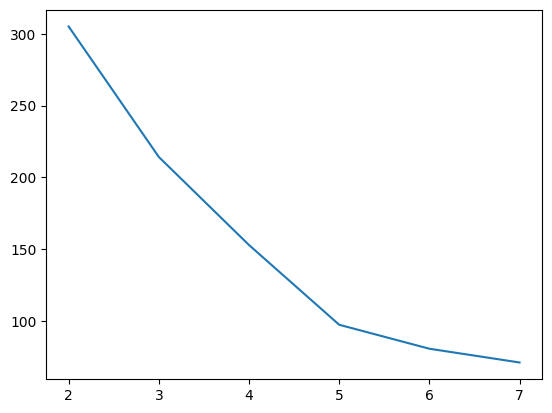

In [12]:
cost = []
for k in range(2, 8):
    kprototype_model = KPrototypes(n_clusters=k)
    kprototype_predict = kprototype_model.fit_predict(preprocessed_df, categorical = [2])
    cost.append(kprototype_model.cost_)

plt.plot(np.arange(2,8), cost, '-')


As chart shows kprototype model cost less with 5 clusters

In [13]:
kprototype_model = KPrototypes(n_clusters=5)
kprototype_predict = kprototype_model.fit_predict(preprocessed_df, categorical = [2])
kprototype_model.cost_

97.40721950868532

In [14]:
silhouette_score(preprocessed_df.drop(columns='Gender'), kprototype_predict)

0.5674183619384842

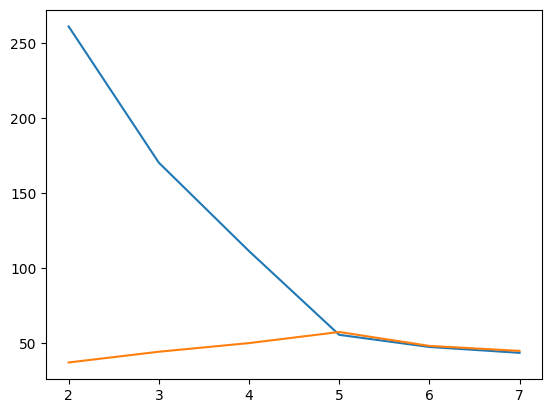

In [15]:
numerical_df = preprocessed_df.drop(columns='Gender')
inertia = []
s_score = []
for k in range(2, 8):
    kmean_model = KMeans(n_clusters = k)
    predict = kmean_model.fit_predict(numerical_df)
    inertia.append(kmean_model.inertia_)
    s_score.append( silhouette_score(numerical_df, predict)*100 )

plt.plot(np.arange(2,8), inertia, '-')
plt.plot(np.arange(2,8), s_score, '-');

According to chart kmean model work best with 5 clusters

In [16]:
kmean_model = KMeans(n_clusters = 5, init='k-means++', random_state=0)
kmean_predict = kmean_model.fit_predict(numerical_df)
silhouette_score(numerical_df, kprototype_predict)

0.5674183619384842

To better compare the two models—one using KMeans and the other KPrototypes—I used the silhouette score calculated on the numerical columns of the dataframe trained with KPrototypes which are the equal.

As kmean is faster and less complicated, choosing kmean model is better.

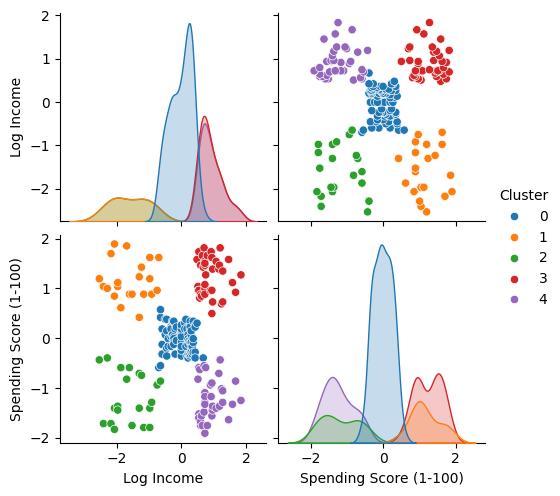

In [17]:
numerical_df['Cluster'] = kmean_predict
sns.pairplot(numerical_df, hue="Cluster", palette="tab10")